# Computational Statistics 2020-2021
## Article implementation: "Convergence of Markovian Stochastic Approximation with Discontinuous Dynamics" - Arthur Stéphanovitch and Linus Bleistein

This code implements the algorithm from the article [Convergence of Markovian Stochastic Approximation With Discontinous Dynamics](https://hal.archives-ouvertes.fr/hal-01418857).

In [579]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
import math
import scipy as sp
from scipy.stats import multivariate_normal as mvn
from matplotlib import cm
from sklearn.datasets import make_blobs


## The algorithm

The presented article introduces a classical stochastic approximation algorithm but extends it to discontinous dynamics. Iterations of the algorithm can be computed through 

$$\theta_{n+1} = \theta_n + \frac{\gamma_0}{1+n+I_n} H_{\theta_n}(X_n).$$ 

## Application to quantile estimation: a toy example

The code bellow approximates the q-quantile of a normal distribution using the algorithm given in the article. Iterations of the algorithm write 
$$\theta_{n+1} = \theta + \frac{\gamma_0}{1+I_n+n}X_n,$$
where $X_n$ is drawn from a normal distribution and $I_n$ is the number of the set the sequences currently lives in. Using notations of the original article, this corresponds to the toy case where $\phi(x) = x$ and $P_\theta(x,\cdot) = \pi(\cdot) = \mathcal{N}(m,\sigma)$.

In [774]:
mean = 0
variance = 1

q = 9/10
x0 = 4
theta0 = 0.9
gamma0 = 10
n_sets = 100
precision = 3e-6


In [779]:
xes = []
thetas = []
end = 0

for i in np.arange(1,n_sets):
    
    x = x0
    theta = theta0
    j = 0 
        
    while np.abs(theta) < norm.ppf(q) + i/3: #Parametrization of sets K_i, centered around the true q-quantile

        x = np.random.normal(mean,variance)
    
        if x > theta:

            h = 0
        else:

            h = 1
        
        theta = theta + gamma0/((1+i+j))*(q-h)
        
        j += 1 
        
        xes.append(x)
        thetas.append(theta)
        
        if np.abs(norm.cdf((theta-mean)/variance)-q) < precision or j==20000:
            
            end = 1
            
            break
            
    if end:
        
        break

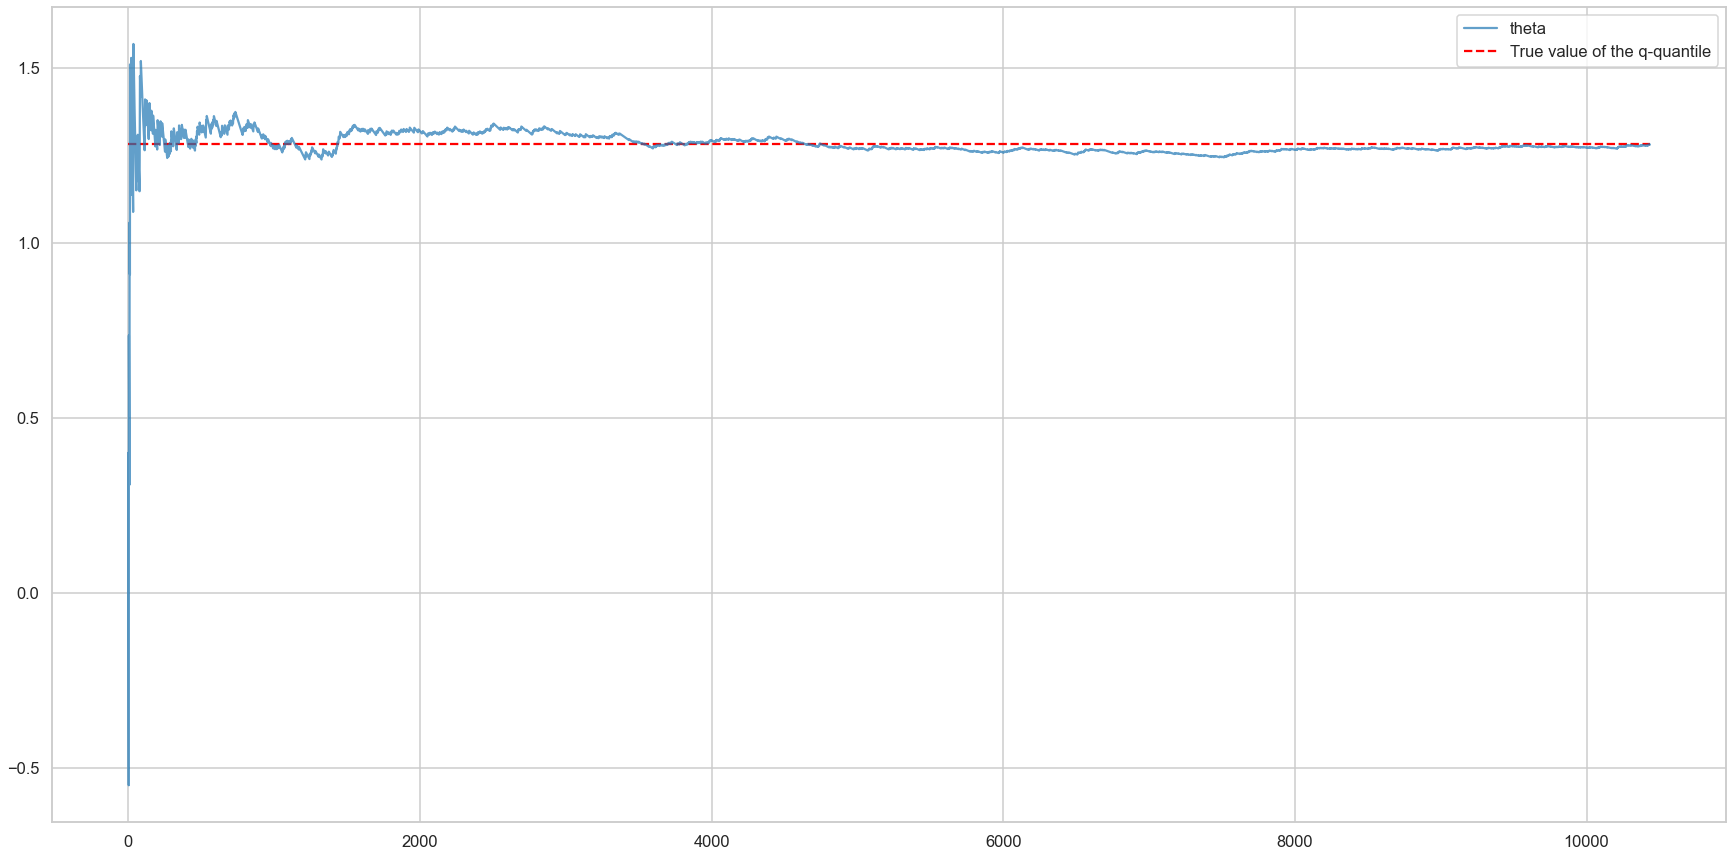

In [780]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig,ax = plt.subplots(figsize=(30,15))
ax.plot(thetas, alpha=0.7, label='theta')
ax.hlines(norm.ppf(q),xmin=0,xmax=len(thetas), color='red',linestyle='--', label='True value of the q-quantile')
ax.legend()
plt.show()

## Application to median in multi-dimensional spaces estimation

Consider a random variable $X$ with probability distribution $\pi$ on $\mathbb{R}^d$. In this application, we are interrested in solving the problem 

$$\text{argmin}_{m \in \mathbb{R}^d} \mathbb{E}\left(||X-m||\right), $$
which can be seen as finding the multidimensional equivalent of the median.

### Median of a gaussian distribution

In this example, we compute the median of a gaussian distribution (which is equal to its mean, even in higher dimensions).

In [368]:
mean = np.array([2,2])
variance = np.array([[2,-1],[-1,1]])
q = 9/10
x0 = np.array([3,4])
theta0 = np.array([0.3,0.8])
gamma0 = 10
n_sets = 100
precision = 3e-3


In [369]:
xes = []
thetas = []
end = 0

for i in np.arange(1,n_sets):
    
    x = x0
    theta = theta0
    j = 0 
        
    while np.abs(theta[0]) <  mean[0] + i/100 and np.abs(theta[1]) < mean[1] + i/100: #Parametrization of sets K_i, centered around the true q-quantile

        x = variance@np.random.randn(2) + mean
    
        if x[0] == theta[0] and x[1] == theta[1]:

            h = 0
        
        else:

            h = (x-theta)/np.linalg.norm(x-theta)
        
        theta = theta + gamma0/((1+i+j))*h
        
        j += 1 
        
        xes.append(x)
        thetas.append(theta)
        
        if j == 10000:
            
            end = 1
            
            break
    if end:
        
        break


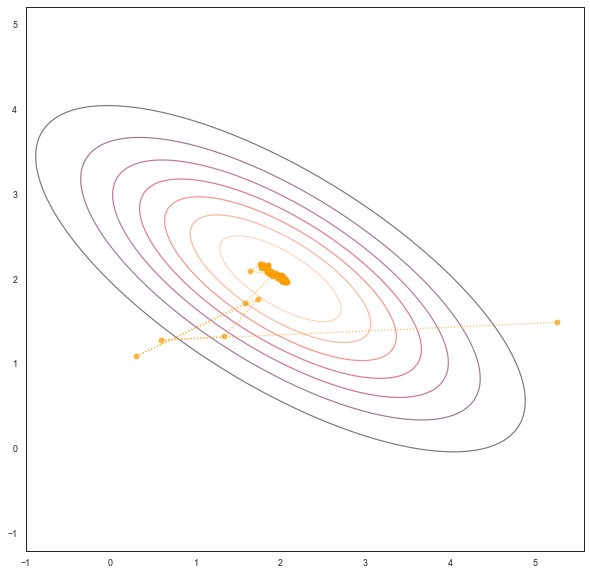

In [370]:
x, y = np.meshgrid(np.linspace(-1,5,100),np.linspace(-1,5,100))
xy = np.column_stack([x.flat, y.flat])

z = mvn.pdf(xy, mean, variance).reshape(x.shape)

thetas= np.array(thetas)
step= int(len(thetas)/130)

thetas_plot = thetas[0::step]

sns.set_style('white')

f,ax = plt.subplots(figsize=(10,10))

ax.contour(x, y, z,alpha=0.6)
ax.plot(thetas_plot[:,0],thetas_plot[:,1],alpha=0.7,linestyle='dotted',marker='o',color=cm.inferno(200))
plt.gca().axis('equal')
plt.show()


### Median of a mixture of gaussians

In this example, we compute the median of a mixture of 3 gaussian distributions.

In [324]:
means = np.array([[-1,-3], [3,1/2], [-2,3.5]])
variance0 = np.array([[2,-1],[-1,1]])
variance1 = np.array([[2,0],[0,1]])
variance2= np.array([[2,-1],[-1,2]])
mm = np.mean(np.array([[1,2], [3,1/2], [0,1]]),axis=0)
q = 9/10
x0 = np.array([4,0])
theta0 = np.array([2,-2])
gamma0 = 30
n_sets = 10000
precision = 3e-1


In [180]:
def gaussian_mixture():
    
    variances= np.vstack((variance0,variance1,variance2))
        
    randomint = np.random.choice(3)
    
    variance = variances[2*randomint:2*randomint+2]
    
    return variance@np.random.randn(2) + means[randomint]
    
    

In [409]:
xes = []
thetas = []
end = 0 

for i in np.arange(1,n_sets):
    
    x = x0
    theta = theta0
    j = 0 
        
    while np.abs(theta[0]) < i/100 and np.abs(theta[1]) < i/100: #Parametrization of sets K_i, centered around the true q-quantile
        
        x = gaussian_mixture()
    
        if x[0] == theta[0] and x[1] == theta[1]:

            h = 0
        
        else:

            h = (x-theta)/np.linalg.norm(x-theta)
        
        theta = theta + gamma0/((1+i+j))*h
        
        j += 1 
        
        xes.append(x)
        thetas.append(theta)
        
        if j == 40000:
            
            end = 1
            
            break
            
    if end:
            
        break

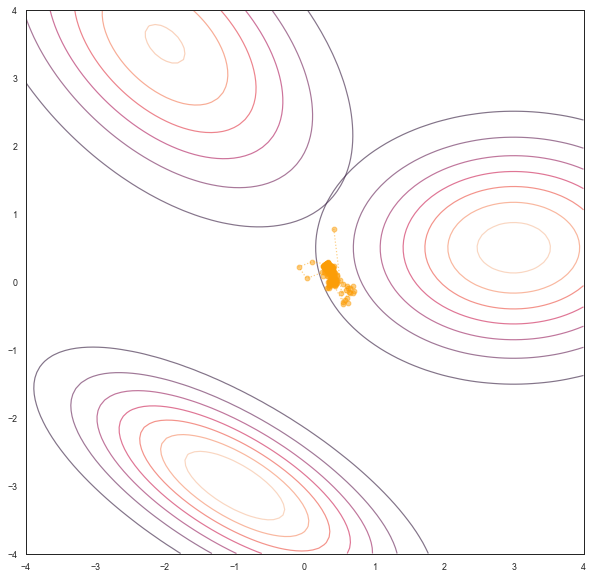

In [412]:
x, y = np.meshgrid(np.linspace(-4,4,100),np.linspace(-4,4,100))
xy = np.column_stack([x.flat, y.flat])

z0 = mvn.pdf(xy, means[0], variance0).reshape(x.shape)
z1 = mvn.pdf(xy, means[1], variance1).reshape(x.shape)
z2 = mvn.pdf(xy, means[2], variance2).reshape(x.shape)


thetas= np.array(thetas)
step= int(len(thetas)/2000)

thetas_plot = thetas[0::step]

sns.set_style('white')

f,ax = plt.subplots(figsize=(10,10))
                    
ax.contour(x, y, z0,alpha=0.6)
ax.contour(x, y, z1,alpha=0.6)
ax.contour(x, y, z2,alpha=0.6)
ax.plot(thetas_plot[:,0],thetas_plot[:,1],alpha=0.5,linestyle='dotted',marker='o',color=cm.inferno(200))
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
plt.show()



/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


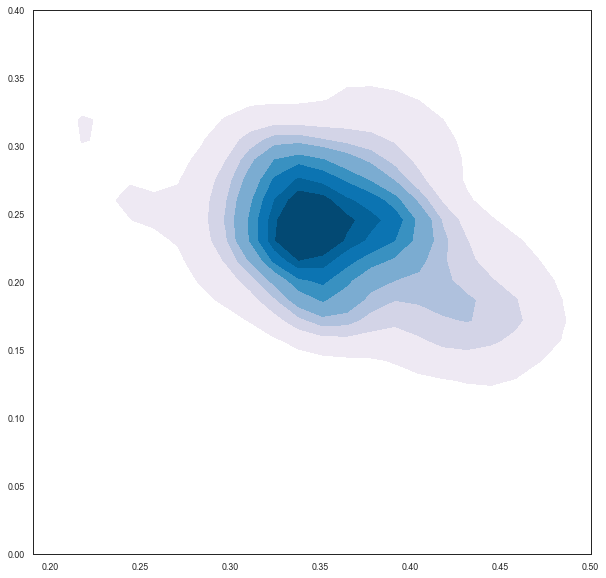

In [366]:
sns.set_style('white')
sns.set_context('paper')

f,ax=plt.subplots(figsize=(10,10))
ax = sns.kdeplot(thetas[:,0],thetas[:,1], shade = True, cmap = "PuBu")
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlim(0.19,0.5)
ax.set_ylim(0,0.4)
plt.show()

## Application to vector quantilization

In this last example, we apply the algorithm to vector quantilization. Quantilization consists in approximation data points through a finite number of points, choosen in order to minimize an approximation error.

Let $X$ be a random variable in $\mathbb{R}^d$ with distribution $\pi$. We wish to find $\theta = (\theta_1,\dots,\theta_N)$ in $(\mathbb{R}^d)^N$ in order to minimize the mean square quantilization error 

$$ \sum\limits_{i=1}^N \mathbb{E}_\pi (\, ||X-\theta_i|| \, \mathbb{1}_{C_i(\theta)}(X)),$$

where $C_i(\theta)$ is the i-th Voronoï cell associated to the dictionnary $\theta$, i.e. 

$$C_i(\theta) := \left\{u \,\text{  s.t.  }\, ||u-\theta_i|| = \min\limits_{1 \leq j \leq N} ||u-\theta_j|| \right\}. $$

The i-th Voronoï cell is simply the set of points that are closer in $L_2$ norm to $\theta_i$ than to all other $\theta_j$'s. The computation of these cells is done through the article's algorithm, with the field 

$$ H_\theta(x) := -2\left((\theta_i-x)\mathbb{1}_{C_i(\theta)}(x)\right)_{1 \leq i \leq N} - \mu \left( \sum\limits_{i \neq j} \frac{\theta_i - \theta_j}{||\theta_i - \theta_j||^4}\right)_{1 \leq i \leq N} \in (\mathbb{R}^d)^N.$$

$\mu$ is a hyperparameter.

In [762]:
x0 = np.array([4,0])
theta0 = np.array([[1,0],[1,1],[-1,-1]])
gamma0 = 1
n_sets = 10000
precision = 3e-1
centers = np.array([[-5.23905046,8.29097266],[-7.056815,-2.48099877],[ 8.72688666,-1.12136438]])


The function `voronoi_center` returns the index of the closest center to a given point $x$.

In [763]:
def voronoi_center(x,centers):
        
    distances = np.array([[np.linalg.norm(x-centers[0])],[np.linalg.norm(x-centers[1])],[np.linalg.norm(x-centers[2])]])
    
    return np.argmin(distances)

In [764]:
def field(x,theta,mu):
    
    vorcenter = voronoi_center(x,theta)
    
    vector1 = np.array([[0,0],[0,0],[0,0]])
        
    vector1[vorcenter] = theta[vorcenter] - x
    
    z = np.array([[0,0],[0,0],[0,0]],dtype=np.float64)
        
    z[0] += (theta[0]-theta[1])/(np.linalg.norm(theta[0]-theta[1])**4) + (theta[0]-theta[2])/(np.linalg.norm(theta[0]-theta[2])**4)
    
    
    z[1] += (theta[1]-theta[0])/(np.linalg.norm(theta[1]-theta[0])**4) + (theta[1]-theta[2])/(np.linalg.norm(theta[1]-theta[2])**4)
    
    z[2] += (theta[2]-theta[0])/(np.linalg.norm(theta[2]-theta[0])**4) + (theta[2]-theta[1])/(np.linalg.norm(theta[2]-theta[1])**4)
    
    return -2*vector1 - mu*z

    

Display some samples of the probability distribution $\pi$.

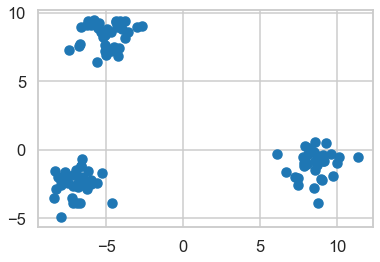

In [765]:
data,label = make_blobs(100,2, centers= centers)

plt.scatter(data[:,0],data[:,1])
plt.show()

In [766]:
xes = []
thetas = []
end = 0 
mu = 1

for i in np.arange(1,n_sets):
    
    x = x0
    theta = theta0
    j = 0 
    
    distances = sp.spatial.distance_matrix(theta,theta)
    
    for i in np.arange(3):
        
        distances[i,i] = 1000
        
    while np.min(distances) > 1/i: #Parametrization of sets K_i
        
        blobs,y=make_blobs(10,2, centers= centers)
        
        x = blobs[np.random.choice(10),:]
                
        h = field(x,theta,mu)        
                        
        theta = theta + gamma0/((1+i+j))*h
        
        distances = sp.spatial.distance_matrix(theta,theta)
        
        for i in np.arange(3):
            
            distances[i,i] = 1000
        
        j += 1 
        
        xes.append(x)
        thetas.append(theta)
        
        if j == 40000:
            
            end = 1
            
            break
            
    if end:
            
        break

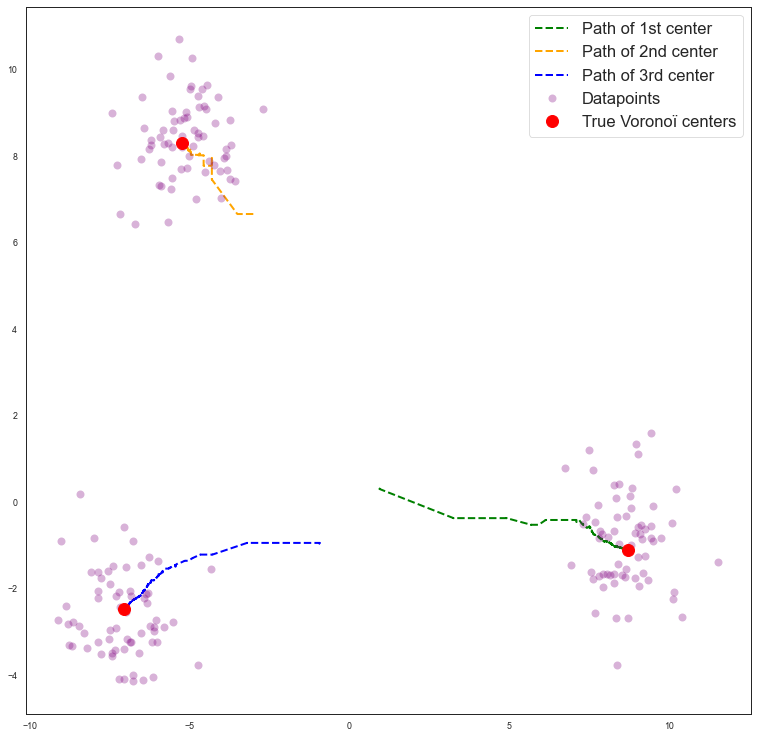

In [769]:
sns.set_context('paper')
sns.set_style('white')

data,label = make_blobs(200,2,centers= centers)

thetas = np.array(thetas)

f,ax = plt.subplots(figsize=(13,13))

ax.plot(thetas[:,0,0],thetas[:,0,1],linestyle='--',linewidth=2,c='green',label='Path of 1st center')
ax.plot(thetas[:,1,0],thetas[:,1,1],linestyle='--', linewidth=2,c='orange',label='Path of 2nd center')
ax.plot(thetas[:,2,0],thetas[:,2,1],linestyle="--",linewidth=2,c='blue', label='Path of 3rd center')
ax.plot(data[:,0],data[:,1],alpha=0.3, c='purple', label='Datapoints', linestyle='',marker='o',markersize=8,markeredgewidth=0.0)
ax.plot(centers[0,0],centers[0,1],marker='o',markersize=12,c='red',linestyle='', label='True Voronoï centers')
ax.plot(centers[1,0],centers[1,1],marker='o',markersize=12,c='red')
ax.plot(centers[2,0],centers[2,1],marker='o',markersize=12,c='red')
ax.legend(fontsize='xx-large')
plt.show()

The cell bellow displays the distance between the true centers and the centers as computed by the algorithm through iterations of the algorithm. Convergence speed seems to be sublinear.

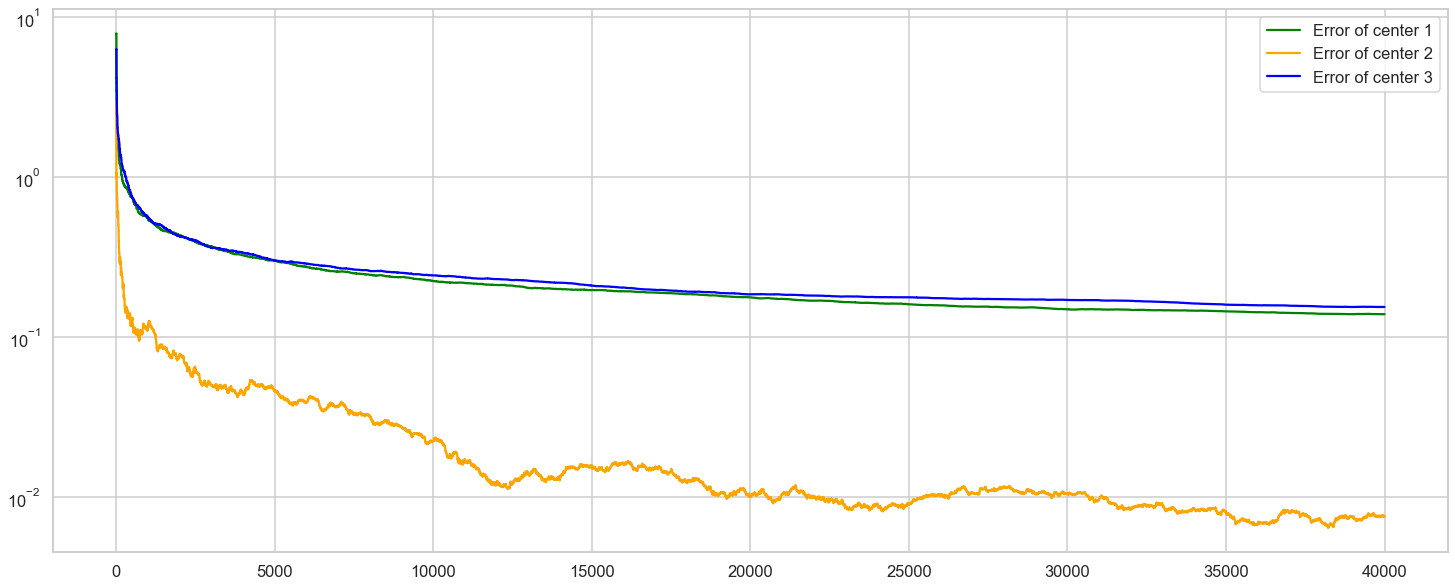

In [771]:
sns.set_style('whitegrid')
sns.set_context('talk')

f,ax = plt.subplots(figsize=(25,10))

error1 = np.linalg.norm(thetas[:,0,:]-centers[2],axis=1)
error2 = np.linalg.norm(thetas[:,1,:]-centers[0],axis=1)
error3 = np.linalg.norm(thetas[:,2,:]-centers[1],axis=1)
ax.set_yscale('log')
ax.plot(error1,c='green', label="Error of center 1")
ax.plot(error2,c='orange', label="Error of center 2")
ax.plot(error3,c='blue', label = "Error of center 3")
ax.legend()